# GEOG 4563-5563 Final Project Proposal - Blog Post

### **Modelling The impact of changing climate patterns on dryland cropping regions in Western Australia**


**Introduction**

In this blog post I intend to lay out the work to date that I have done in the project design of a model which seeks to draw predictive solutions out of satellite imagery to estimate dryland cropping performance in Australia. There has been a wealth of research in recent years focused on the relationship between NDVI and cropping performance, crop health and yield which can be leveraged to guide the development of this project.

**Purpose**

The purpose of this project is investigate the extent to which dryland cropping performance correlates to changing weather patterns in Western Australia. It is understood that in the Wheatbelt region of Western Australia, that the North East sires in the region are more exposed to changing weather patterns that impact cropping performance (lower rainfall, El Niño and La Niña events): [Link to Western Australian government source with more detail](https://www.agric.wa.gov.au/climate-change/climate-change-and-broadacre-cropping-western-australia). 

Because of the economic significance of the agricultural industry to Western Australia (60 billion AUD gross value add in 2018-19) and the long-term food security concerns linked to dryland agriculture there is allot of potential for more research and modelling in the space. Because of development in computational processing and programming, as well as the greater availability of accessible and open-source imagery, there is now opportunity for more reproducible and temporal analysis into the ongoing relationship between climate and cropping performance.


**Newdegate Grain Terminal, WA: Photo: Annette Green, by artist Brenton See**

![Photo: Annette Green](pics\silo-1.png 'Newdegate Grain Terminal, WA: Photo: Annette Green, by artist Brenton See')

**Workflow & Methodology**

The following flowchart details the simple process and workflow for the analysis done to date and still to do. In the final project there will be a much more extensive workflow and process map will be provided. 

The modelling follows 4 stages

- Data sourcing and downloading
- Cleaning and processing 
- Modelling 
- Results 

The workflow as it stands has been kept relatively simple to allow for scalability to other regions when entering the final project development phase.

![Flow](pics\flow.jpg 'High-Level Project Workflow and Methodology')

In [1]:
# Import necessary packages

import os
import fiona
from glob import glob

# import netCDF4 #To be used for Silo API once I get it running

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy import stats

from shapely.geometry import box, MultiPolygon, Polygon, mapping
import geopandas as gpd

import xarray as xr
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from rasterio.crs import CRS
import rioxarray as rxr

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from sentinelsat import SentinelAPI

import folium 

In [2]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'final-project',
                      'data'))

**Area of interest (AOI)**

For this study sample I have used the LGA (Local Government Area) of Merredin, which is located in the north-east of the Wheatbelt region. This AOI has been selected for the testing because the shire falls within a region of the Wheatbelt that is considered to be at risk from dryer autumn and winter seasons, as well as being almost all wheat crops. Because sub-classifying wheat cropping from canola and barley is a very challenging classification task, I am using an area known for being mostly uni-cropped. Once the model has been developed using this AOI, my intention is to reproduce and loop the model through the other 5 or 6 shires in the north-east wheatbelt, in order to compare my results against the available grain yield and sales data which is only available at that larger geographic level.

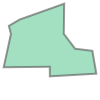

In [3]:
# Import AOI shapefile
merredin = gpd.read_file('merredin-shape/merredin-shape.shp')

footprint = None
for i in merredin['geometry']:
    footprint = i.simplify(0.05, preserve_topology = True)
    
footprint

**Landsat Worldwide Reference System**

The next snippet of code imports the shapefile for the Landsat Worldwide Reference System, I then intersect with the Merredin shapefile to determine which row and path is required for my Landsat API query. For the final reproducible model, the code will pull these shapefiles from the web, they have been downloaded locally to save time when model testing.

In [4]:
wrs = gpd.read_file('wrs2/wrs2.shp')

wrs_intersect = wrs[wrs.intersects(merredin.geometry[0])]

paths, rows = wrs_intersect['PATH'].values, wrs_intersect['ROW'].values

wrs_intersect

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
15333,3.01844,7.01528,1818.0,1818.0,1,0,110,82,D,29098,110082,110082,9,1,"POLYGON ((118.54862 -32.31569, 118.95700 -30.8..."
27981,3.01844,7.01528,1818.0,1818.0,1,0,111,82,D,54394,111082,111082,16,8,"POLYGON ((117.00362 -32.31569, 117.41200 -30.8..."


In [5]:
# Get the center of the map
xy = np.asarray(merredin.centroid[0].xy).squeeze()
center = list(xy[::-1])

# Select a zoom
zoom = 6

# Create the most basic OSM folium map
m = folium.Map(location = center, 
               zoom_start = zoom, 
               control_scale = True)

# Add the bounds GeoDataFrame in red
m.add_child(folium.GeoJson(merredin.__geo_interface__,  
                           name = 'Area of Study', 
                           style_function = lambda x: {'color': 'red', 'alpha': 0}))

# Iterate through each Polygon of paths and rows intersecting the area
for i, row in wrs_intersect.iterrows():
    # Create a string for the name containing the path and row of this Polygon
    name = 'path: %03d, row: %03d' % (row.PATH, row.ROW)
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(row.geometry.__geo_interface__, 
                       name = name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(m)

folium.LayerControl().add_to(m)
m.save('./wrs.html')

<ipython-input-5-1dca33f89bba>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy = np.asarray(merredin.centroid[0].xy).squeeze()


In [6]:
m

In [7]:
# Links to open-source landsat 8 databases

# Google: google_scenes = pd.read_csv('https://storage.googleapis.com/gcp-public-data-landsat/index.csv.gz', compression= 'gzip')
# Amazon: s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression = 'gzip')

# Downloaded locally for speed 
s3_scenes = pd.read_csv('scene_list.gz', compression = 'gzip')

In [8]:
# Read in the Merredin imagery list

s3 = s3_scenes[(s3_scenes['path'] == 111) & (s3_scenes['row'] == 82) & (s3_scenes['cloudCover'] < 5)]

s3.head()

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
4111,LC08_L1TP_111082_20170401_20170414_01_T1,LC81110822017091LGN00,2017-04-01 01:58:51.674661,0.08,L1TP,111,82,-32.81339,116.97223,-30.68867,119.46771,https://s3-us-west-2.amazonaws.com/landsat-pds...
10425,LC08_L1TP_111082_20170316_20170328_01_T1,LC81110822017075LGN00,2017-03-16 01:58:59.923950,0.02,L1TP,111,82,-32.81339,116.97223,-30.68867,119.46771,https://s3-us-west-2.amazonaws.com/landsat-pds...
36976,LC08_L1TP_111082_20170503_20170515_01_T1,LC81110822017123LGN00,2017-05-03 01:58:33.568693,2.06,L1TP,111,82,-32.81339,116.96261,-30.68867,119.45811,https://s3-us-west-2.amazonaws.com/landsat-pds...
73782,LC08_L1TP_111082_20170620_20170620_01_RT,LC81110822017171LGN00,2017-06-20 01:59:01.044768,0.04,L1TP,111,82,-32.81338,116.93697,-30.68866,119.43250,https://s3-us-west-2.amazonaws.com/landsat-pds...
88239,LC08_L1TP_111082_20170620_20170630_01_T1,LC81110822017171LGN00,2017-06-20 01:59:01.044768,0.04,L1TP,111,82,-32.81338,116.93697,-30.68866,119.43250,https://s3-us-west-2.amazonaws.com/landsat-pds...


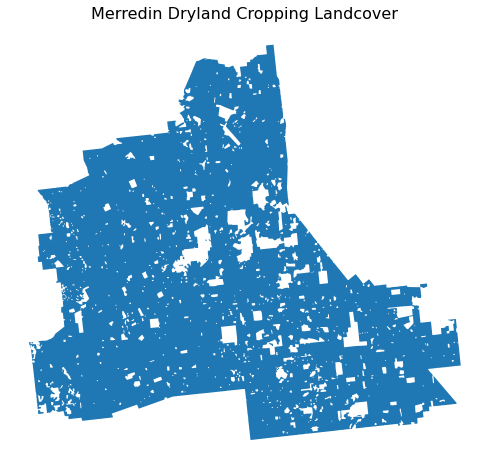

In [9]:
dryland_clip = gpd.read_file('merredin-shape/merredin-dry.shp')

# create the plot
fig, ax = plt.subplots(figsize = (12,8))

# plot the data 
dryland_clip.plot(ax=ax)

ax.set_title('Merredin Dryland Cropping Landcover', fontsize = 16)
ax.set_axis_off()


**Weather Data**

For this post, I have not gathered the temporal imagery that will facilitate monthly analysis of changing NDWI over the Winter period. Below I have pulled in the data from the Australian Bureau of Meteorology and saved the data down locally, I have imported the data to demonstrate the seasonal trend in weather historically for Merredin.

In [10]:
merredin = pd.read_csv('merredin_weather.csv')

merredin_grp =  merredin.groupby('Month').agg({'Rainfall amount (millimetres)': 'sum'})
merredin_grp = merredin[merredin['Year'] > 2009].groupby(['Year','Month']).sum().reset_index()
merredin_grp['rain_cumulative'] = merredin_grp.groupby(['Year'])['Rainfall amount (millimetres)'].apply(lambda x: x.cumsum())

merredin_cum = merredin_grp.groupby(['Year', 'Month']).cumsum().reset_index()

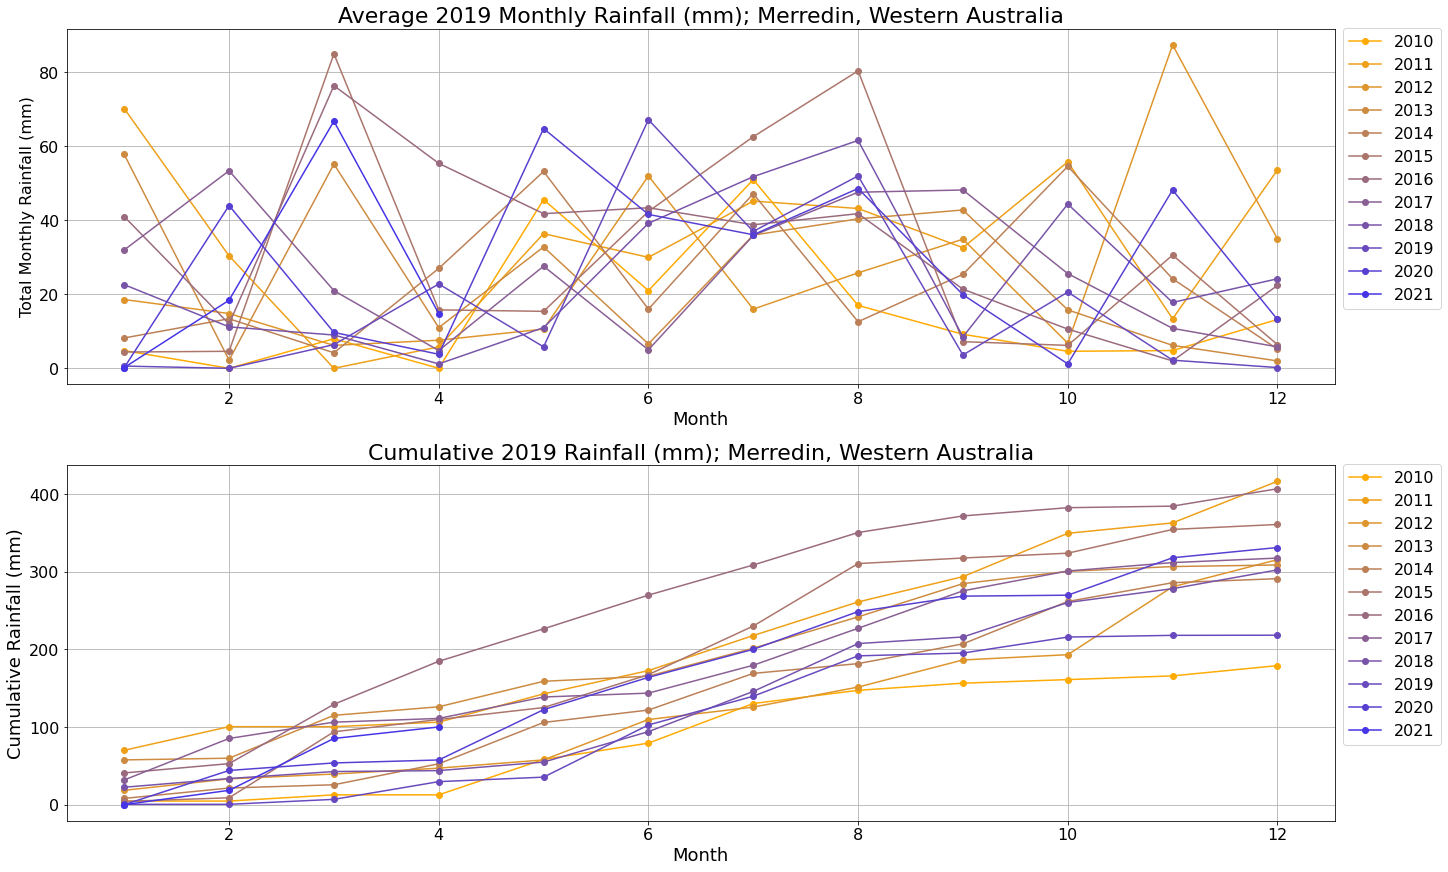

In [11]:
color_map = {2010 : '#FFAB03', 
             2011 : '#EEA018', 
             2012 : '#DD952C', 
             2013 : '#CD8B41', 
             2014 : '#BC8056', 
             2015 : '#AB756B',
             2016 : '#9A6A7F',
             2017 : '#895F94',
             2018 : '#7854A9',
             2019 : '#684ABE',
             2020 : '#573FD2',
             2021 : '#4634E7'}

fig, (ax1, ax2) = plt.subplots(2, 1, 
                               figsize = (20,12),  
                               constrained_layout = True)

for label, grp in merredin_grp.groupby("Year"):
    grp.plot(use_index = True,
             x = 'Month',
             y = 'Rainfall amount (millimetres)',
             ax = ax1,
             color = color_map[label],
             label = label,
             style = '.-',
             markersize = 12)

    
# Set up formatting for graph 

ax1.set_xlabel('Month', fontsize=18)
ax1.set_ylabel('Total Monthly Rainfall (mm)', fontsize=16)

ax1.legend(fontsize = 16,
           bbox_to_anchor = (1, 1.025), 
           loc = 'upper left')

ax1.tick_params(axis = 'both',
                which = 'major', 
                labelsize = 16)

ax1.grid(True)

ax1.set_title("Average 2019 Monthly Rainfall (mm); Merredin, Western Australia", fontsize = 22)

for label, grp in merredin_grp.groupby("Year"):
    grp.plot(use_index = True,
             x = 'Month',
             y = 'rain_cumulative',
             ax = ax2,
             color = color_map[label],
             label = label,
             style = '.-',
             markersize = 12)

    
# Set up formatting for graph 

ax2.set_xlabel('Month', fontsize = 18)
ax2.set_ylabel('Cumulative Rainfall (mm)', fontsize = 18)

ax2.legend(fontsize = 16,
           bbox_to_anchor = (1, 1.025), 
           loc = 'upper left')

ax2.tick_params(axis = 'both',
                which = 'major', 
                labelsize = 16)

ax2.set_title("Cumulative 2019 Rainfall (mm); Merredin, Western Australia", fontsize = 22)


ax2.grid(True)



In [12]:
def combine_tifs(tif_list):
    
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """
    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked = True).squeeze())
        out_xr[i]["band"] = i + 1

    return xr.concat(out_xr, dim = "band")

In [13]:
sow_data_path = "landsat\sowing\LC08_L1TP_111082_20190525_20190605_01_T1_B*[0-11]*.tif"
sow_paths = glob(sow_data_path)
sow_paths.sort()
sow_path = sow_paths[0:6]

In [14]:
sow_tif = combine_tifs(sow_path)
dryland_clip_crs = dryland_clip.to_crs(sow_tif.rio.crs)
sow_clip = sow_tif.rio.clip(dryland_clip_crs.geometry.apply(mapping))

In [15]:
harvest_data_path = "landsat\pre-harvest\LC08_L1TP_111082_20190930_20191017_01_T1_B*[0-11]*.tif"
harvest_paths = glob(harvest_data_path)
harvest_paths.sort()
harvest_path = harvest_paths[0:6]

In [16]:
harvest_tif = combine_tifs(harvest_path)
dryland_clip_crs = dryland_clip.to_crs(harvest_tif.rio.crs)
harvest_clip = harvest_tif.rio.clip(dryland_clip_crs.geometry.apply(mapping))

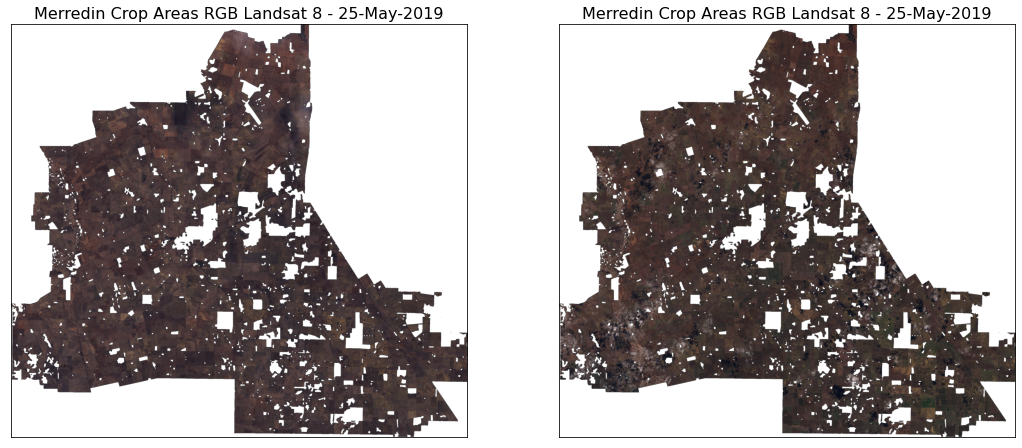

In [17]:
# Create nan mask
sow_mask = np.isnan(sow_clip)
harvest_mask = np.isnan(harvest_clip)

# Apply nan mask to cropped data
sow_masked = ma.masked_array(sow_clip,
                             mask = sow_mask)

# Apply nan mask to cropped data
harvest_masked = ma.masked_array(harvest_clip,
                                 mask = harvest_mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,12))

# Plot masked array
ep.plot_rgb(sow_masked,
            rgb=[3, 2, 1],
            ax = ax1)

ax1.set_title("Merredin Crop Areas RGB Landsat 8 - 25-May-2019", fontsize = 16)

# Plot masked array
ep.plot_rgb(harvest_masked,
            rgb=[3, 2, 1],
            ax = ax2)

ax2.set_title("Merredin Crop Areas RGB Landsat 8 - 25-May-2019", fontsize = 16)

plt.show()

In [18]:
sow_ndvi = es.normalized_diff(sow_masked[4], sow_masked[3])
harvest_ndvi = es.normalized_diff(harvest_masked[4], harvest_masked[3])

sow_ndwi = es.normalized_diff(sow_masked[4], sow_masked[5])
harvest_ndwi = es.normalized_diff(harvest_masked[4], harvest_masked[5])

ndvi_chg_2019 = harvest_ndvi - sow_ndvi
ndwi_chg_2019 = harvest_ndwi - sow_ndwi

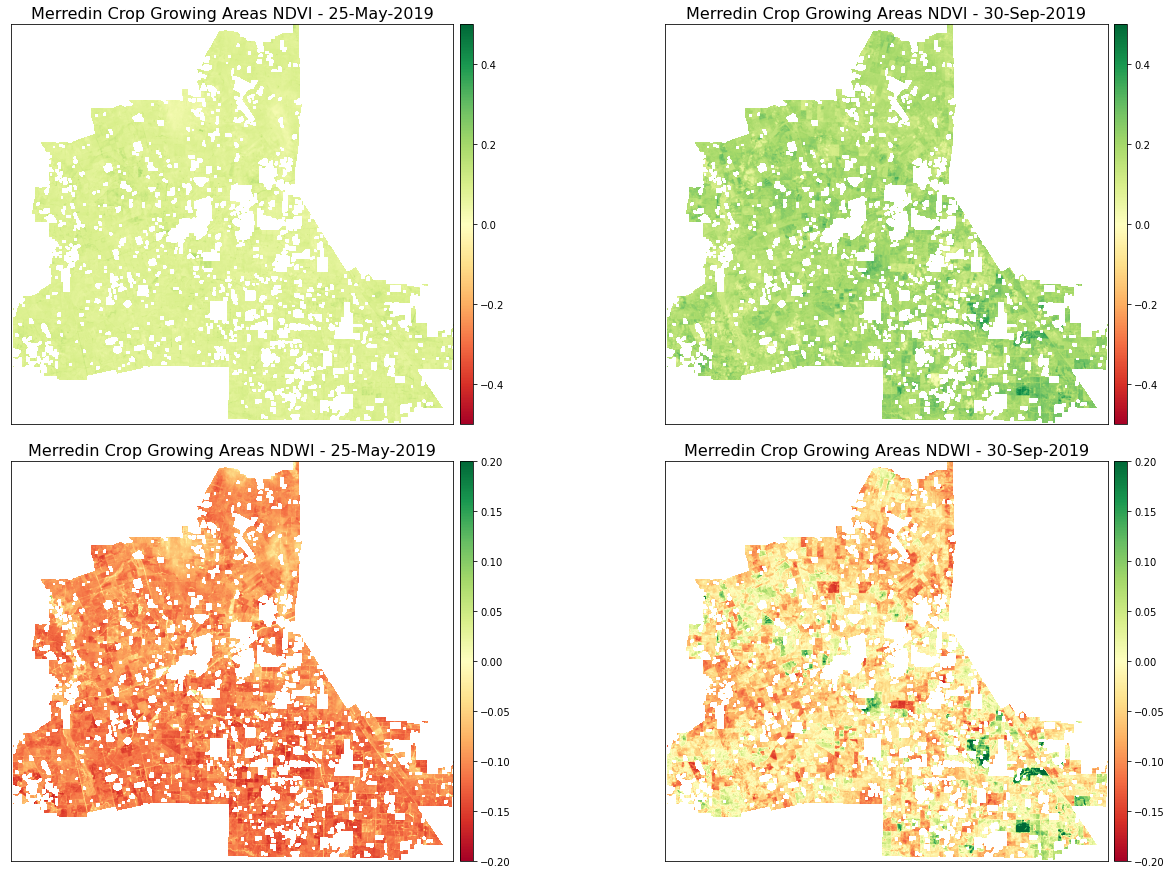

In [19]:
fig, ((ax1, ax2) , (ax3, ax4)) = plt.subplots(2, 2, 
                                              figsize = (18,12), 
                                              constrained_layout = True)

cmap = plt. cm. get_cmap('RdYlGn') 

#Plot Landsat pre-post difference NDVI
ep.plot_bands(sow_ndvi,
              ax = ax1,
              cmap = cmap,
              vmin = -0.5,
              vmax = 0.5)

ax1.set_title("Merredin Crop Growing Areas NDVI - 25-May-2019", fontsize = 16)

#Plot Landsat pre-post difference NDVI
ep.plot_bands(harvest_ndvi,
              ax = ax2,
              cmap = cmap,
              vmin = -0.5,
              vmax = 0.5)

ax2.set_title("Merredin Crop Growing Areas NDVI - 30-Sep-2019", fontsize = 16)

#Plot Landsat pre-post difference NDVI
ep.plot_bands(sow_ndwi,
              ax = ax3,
              cmap = cmap,
              vmin = -0.2,
              vmax = 0.2)

ax3.set_title("Merredin Crop Growing Areas NDWI - 25-May-2019", fontsize = 16)

#Plot Landsat pre-post difference NDVI
ep.plot_bands(harvest_ndwi,
              ax = ax4,
              cmap = cmap,
              vmin = -0.2,
              vmax = 0.2)

ax4.set_title("Merredin Crop Growing Areas NDWI - 30-Sep-2019", fontsize = 16)


plt.show()

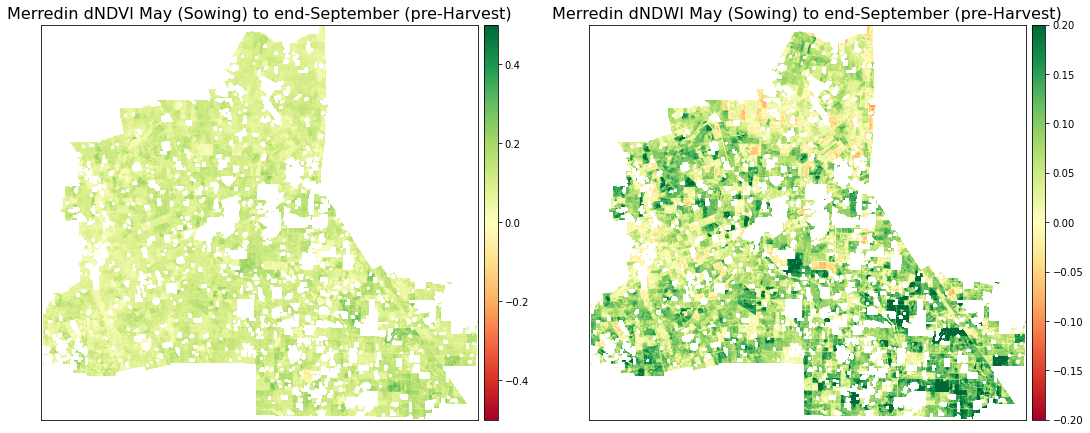

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize = (18,12), 
                               constrained_layout = False)

cmap = plt. cm. get_cmap('RdYlGn') 

#Plot Landsat pre-post difference NDVI
ep.plot_bands(ndvi_chg_2019,
              ax = ax1,
              cmap = cmap,
              vmin = -0.5,
              vmax = 0.5)

ax1.set_title("Merredin dNDVI May (Sowing) to end-September (pre-Harvest)", fontsize = 16)

#Plot Landsat pre-post difference NDVI
ep.plot_bands(ndwi_chg_2019,
              ax = ax2,
              cmap = cmap,
              vmin = -0.2,
              vmax = 0.2,
              title = "Merredin dNDWI May (Sowing) to end-September (pre-Harvest)")

ax2.set_title("Merredin dNDWI May (Sowing) to end-September (pre-Harvest)", fontsize = 16)

plt.show()


**Building the pandas dataframe for regression analysis**

In the below snippits of code I convert the Xarray.DataArrays into a single panda frame that can be cross referenced in the regression plots and stats model runs below

In [21]:
sow_ndwi_df = pd.DataFrame(sow_ndwi).reset_index().melt(id_vars = 'index').dropna()

harvest_ndwi_df = pd.DataFrame(harvest_ndwi).reset_index().melt(id_vars = 'index').dropna()
harvest_ndvi_df = pd.DataFrame(harvest_ndvi).reset_index().melt(id_vars = 'index').dropna()

ndwi_change = pd.DataFrame(ndwi_chg_2019).reset_index().melt(id_vars = 'index').dropna()
ndvi_change = pd.DataFrame(ndvi_chg_2019).reset_index().melt(id_vars = 'index').dropna()

# First rename columns so that we know which belongs to lidar
reg_table = pd.DataFrame(data = {'May NDWI': sow_ndwi_df['value'],
                                 'September NDWI': harvest_ndwi_df['value'],
                                 'September NDVI': harvest_ndvi_df['value'],
                                 'NDWI Winter Change': ndwi_change['value'],
                                 'NDVI Change': ndvi_change['value']})

reg_table

,May NDWI,September NDWI,September NDVI,NDWI Winter Change,NDVI Change
1624,-0.071303,-0.075950,0.118737,-0.004647,0.032644
4018,-0.039161,-0.045059,0.155452,-0.005898,0.059482
4019,-0.057825,-0.072095,0.119975,-0.014270,0.024912
4020,-0.057091,-0.084422,0.116265,-0.027331,0.034430
4023,-0.015854,-0.071318,0.104247,-0.055464,0.028058
...,...,...,...,...,...
6346421,-0.091979,-0.051802,0.202640,0.040176,0.094233
6346422,-0.090566,-0.046288,0.210890,0.044278,0.098239
6346423,-0.079143,-0.051160,0.202217,0.027984,0.084640
6346424,-0.065109,-0.088010,0.163882,-0.022901,0.048107


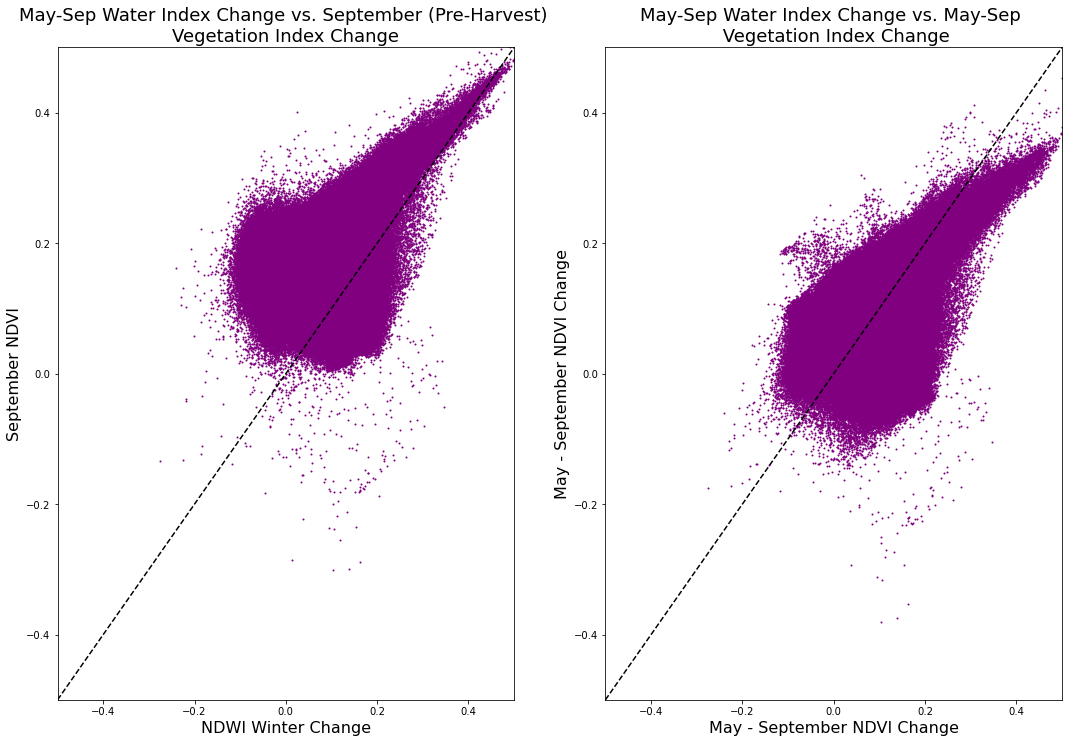

In [22]:
# Plot scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize = (18,12), 
                               constrained_layout = False)

reg_table.plot('NDWI Winter Change', 
               'September NDVI',
               kind = 'scatter', 
               color="purple",
               s = 1, 
               ax = ax1)

# Add a diagonal line

ax1.set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5], label="Data")
ax1.plot((0, 1), 
        (0, 1), 
        transform = ax1.transAxes, 
        ls = '--',
        c = 'k', 
        label = "1:1 line")


ax1.set_title("May-Sep Water Index Change vs. September (Pre-Harvest) \nVegetation Index Change", fontsize = 18)
ax1.set_xlabel("NDWI Winter Change", fontsize=16)
ax1.set_ylabel("September NDVI", fontsize=16)

reg_table.plot('NDWI Winter Change', 
               'NDVI Change',
               kind = 'scatter', 
               color="purple",
               s = 1, 
               ax = ax2)

# Add a diagonal line

ax2.set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5], label="Data")
ax2.plot((0, 1), 
        (0, 1), 
        transform = ax2.transAxes, 
        ls = '--',
        c = 'k', 
        label = "1:1 line")

ax2.set_title("May-Sep Water Index Change vs. May-Sep \n Vegetation Index Change" ,fontsize = 18)
ax2.set_xlabel("May - September NDVI Change", fontsize=16)
ax2.set_ylabel("May - September NDVI Change", fontsize=16)
 
plt.show()

**Regression Model Results**

From the below results we can see some preliminary trends in the data. Whilst there is no sound correlation between the point-in-time May Water Index and the pre-harvest NDVI recorded in September, there is a weak-moderate correlation between the change in NDWI and September NDVI, as well as a trend between the change in NDWI and change in NDVI May - Sep. Whilst these results don't indicate a overwhelmingly strong correlation (ideally we want > 90 R^2 for this project) it is a promising starting point. In order to achieve a stronger correlation, deeper investigation and testing needs to be undertaken to add variables into the regression model. This multiple regression model will look like:

<br>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>Y</mi>
    <mi>i</mi>
  </msub>
  <mo>=</mo>
  <mi>&#x03B1;<!-- α --></mi>
  <mo>+</mo>
  <msub>
    <mi>&#x03B2;<!-- β --></mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mn>1</mn>
    </mrow>
  </msub>
  <msubsup>
    <mi>x</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>i</mi>
    </mrow>
    <mrow class="MJX-TeXAtom-ORD">
      <mo stretchy="false">(</mo>
      <mn>1</mn>
      <mo stretchy="false">)</mo>
    </mrow>
  </msubsup>
  <mo>+</mo>
  <msub>
    <mi>&#x03B2;<!-- β --></mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mn>2</mn>
    </mrow>
  </msub>
  <msubsup>
    <mi>x</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>i</mi>
    </mrow>
    <mrow class="MJX-TeXAtom-ORD">
      <mo stretchy="false">(</mo>
      <mn>2</mn>
      <mo stretchy="false">)</mo>
    </mrow>
  </msubsup>
  <mo>+</mo>
  <mo>.</mo>
  <mo>.</mo>
  <mo>.</mo>
  <mo>.</mo>
  <mo>+</mo>
  <msub>
    <mi>&#x03B2;<!-- β --></mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>n</mi>
    </mrow>
  </msub>
  <msubsup>
    <mi>x</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>i</mi>
    </mrow>
    <mrow class="MJX-TeXAtom-ORD">
      <mo stretchy="false">(</mo>
      <mi>n</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </msubsup>
</math>

In [23]:
slope, intercept, r_value, p_value, std_err = stats.linregress(reg_table["May NDWI"], 
                                                               reg_table["September NDVI"])

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "p value:", p_value)

slope: -0.3986300856466731 
intercept: 0.14620316137836467 
r squared: 0.0645133895636115 p value: 0.0


In [24]:
slope, intercept, r_value, p_value, std_err = stats.linregress(reg_table["September NDWI"], 
                                                               reg_table["September NDVI"])

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "p value:", p_value)

slope: 0.5492290561606904 
intercept: 0.20447457547630202 
r squared: 0.41237616349421646 p value: 0.0


In [25]:
slope, intercept, r_value, p_value, std_err = stats.linregress(reg_table["NDWI Winter Change"], 
                                                               reg_table["September NDVI"])

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "p value:", p_value)

slope: 0.4726160680976953 
intercept: 0.1542210444085356 
r squared: 0.43134015460822617 p value: 0.0


In [26]:
slope, intercept, r_value, p_value, std_err = stats.linregress(reg_table["NDWI Winter Change"], 
                                                               reg_table["NDVI Change"])

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "p value:", p_value)

slope: 0.5133977449710029 
intercept: 0.06494090820061486 
r squared: 0.47366277492382214 p value: 0.0


**Concluding Preliminary Concept Thoughts**

The next steps before embarking on the final project development will be to finalise regression testing against multiple variables, as well as test some spatial aggregations which could focus the model. The weather data I intend to use is gridded and interpolated to a 5 km × 5 km radius, so aggregating and interpolating the imagery up to that grid level would strongly enhance the modelling capability using a range of weather indicators. Another aspect I intend to explore before embarking on the final project development is to look into the monthly NDVI data available through SentinelHUB, whilst this is a proprietary service. Leveraging this service could elevate the burden of downloading >7GB of imagery per year of analysis to undertake monthly temporal modelling.